In [8]:
import quantbt as qbt

data = qbt.data.random_data(seed=100)[0]
print(data)

                  open        high         low       close
date                                                      
2023-01-01   96.500469   97.343832   96.342467   97.185830
2023-01-02   97.185830  100.229609   96.448123   99.491901
2023-01-03   99.491901   99.623296   98.855635   98.987029
2023-01-04   98.987029  101.396866   98.539834  100.949671
2023-01-05  100.949671  102.480134  100.447645  101.978109
...                ...         ...         ...         ...
2025-09-20   58.978186   61.374750   57.945551   60.342115
2025-09-21   60.342115   62.201244   57.007009   58.866138
2025-09-22   58.866138   61.632237   58.752728   61.518828
2025-09-23   61.518828   63.435730   61.455932   63.372835
2025-09-24   63.372835   65.733211   61.438643   63.799019

[998 rows x 4 columns]


In [9]:
import quantbt.indicators as ind
from quantbt.strategies.S_base import S_base
from quantbt.core.enums import CommissionType, DataType, TradeSizeType


class MyStrategy(S_base):
    def generate_signals(self):
        short_period, long_period = params

        self.sma_short = ind.talib_SMA(data.close, period=short_period)
        self.sma_long = ind.talib_SMA(data.close, period=long_period)
        self.long = ind.cross_above(self.sma_short, self.sma_long)
        self.short = ind.cross_below(self.sma_short, self.sma_long)

        return {
            "long_entries": self.long,
            "long_exits": self.short,
            "short_entries": self.short,
            "short_exits": self.long,
        }


st = MyStrategy(
    data,
    commission=1.2,
    commission_type=CommissionType.FIXED,
    multiplier=4,
    data_type=DataType.OHLC,
    initial_capital=100000,
    default_trade_size=1,
    trade_size_type=TradeSizeType.FIXED,
)

In [10]:
params = (5, 23)
st.from_signals(params)

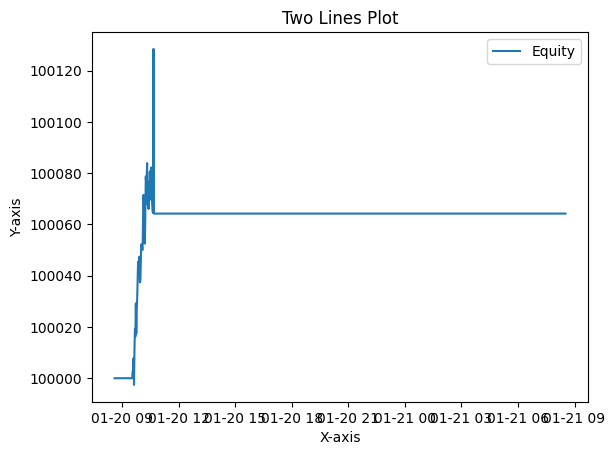

In [11]:
stats = st.get_stats()
trades = st.get_trades()

trades
st.plot_equity()

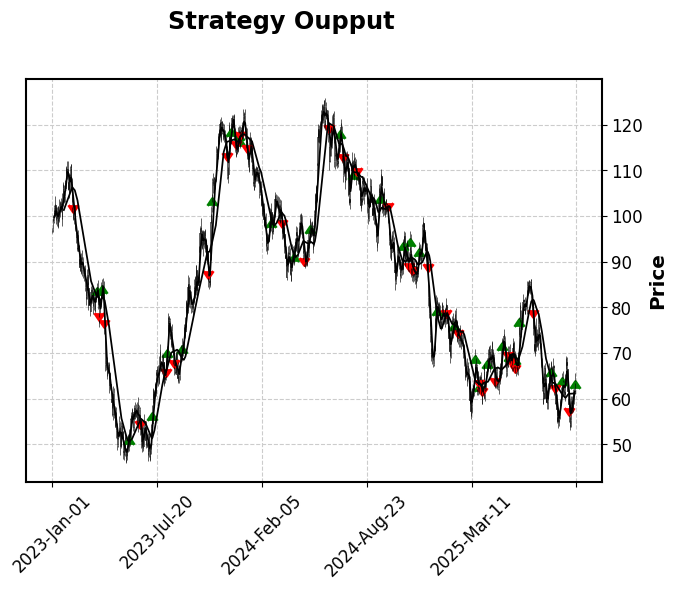

In [12]:
import matplotlib

plotting = qbt.lib.plotting
subplots = [
    plotting.add_line_plot(st.sma_short),
    plotting.add_line_plot(st.sma_long),
    plotting.add_markers(
        st.long, data.close, color="green", marker_type=matplotlib.markers.CARETUP
    ),
    plotting.add_markers(st.short, data.close, color="red"),
]


qbt.lib.plotting.mpf_plot(data, subplots=subplots)